In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [3]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

In [4]:
def ObtainMSE(data, theta0):
    res = ddict(dict)
    for key in data.keys():
        datum = np.squeeze(np.array(data[key]))
        res[key]["Bias"] = np.mean(datum-theta0, axis=1)
        res[key]["Var"] = np.var(datum, axis=1)
        res[key]["MSE"] = np.mean((datum-theta0)**2, axis=1)
    return res

### The work path

In [5]:
root = Path(f"./results/")

## 0. Preprocess the data

In [6]:
def parse_sresult(datum):
    res = {
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPD1" : datum["UIPD1"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "UIPJS1": datum["UIPJS1"]["thetah"],
        "NPP"  : datum["NPP"]["thetah"],
        "LCP"  : datum["LCP"]["thetah"],
        "rMAP" : datum["rMAP"]["thetaP"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "UIPJS":[],
        "UIPD":[],
        "UIPJS1":[],
        "UIPD1":[],
        "NPP":[], 
        "LCP": [],
        "rMAP": []
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["UIPD1"].append(simdatum["UIPD1"])
        retres["UIPJS1"].append(simdatum["UIPJS1"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
        retres["LCP"].append(simdatum["LCP"])
        retres["rMAP"].append(simdatum["rMAP"])
    return retres

In [12]:
n = 60
dirs = root.glob(f"simR1_mean_*_n{n}")

dirs = list(dirs)
dirs = sorted(dirs, key=sortdir, reverse=False)

In [8]:
theta0s = [0.8]
for theta0 in theta0s:
    idxs = np.array([sortdir(d) for d in dirs])/100
    idxs = list(np.sort(idxs))
    
    dirs = sorted(dirs, key=sortdir, reverse=False)
    cdir = dirs[idxs.index(theta0)]
    
    simData = root/f"./SimSimR1_mean_p{sortdir(cdir)}_n{n}.pkl"
    print(simData)
    if simData.exists():
        cleanData = load_pkl(simData)
    else:
        cleanData = save_data(cdir)
        with open(simData, "wb") as f:
            pickle.dump(cleanData, f)

ValueError: 0.8 is not in list

## 1. To obtaining simple format file for a single setting

### Get the current data

In [60]:
theta0 = 0.8
inNum = int(theta0*100)
simData = root/f"./SimSimR1_mean_p{inNum}_n{n}.pkl"

### Obtain the cleaned data

In [61]:
cleanData = load_pkl(simData)
cleanData = edict(cleanData)

### Obtain the mean and variance and MSE from the posterior sample

In [62]:
res = ObtainMSE(cleanData, theta0)

In [63]:
Biass = ddict()
for key in res.keys():
    Biass[key] = res[key]["Bias"]
BiasDF = pd.DataFrame(Biass)

In [64]:
Vars = ddict()
for key in res.keys():
    Vars[key] = res[key]["Var"]
VarDF = pd.DataFrame(Vars)

In [65]:
MSEs = ddict()
for key in res.keys():
    MSEs[key] = res[key]["MSE"]
MSEDF = pd.DataFrame(MSEs)

In [66]:
BiasDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP,LCP,rMAP
0.025,-0.269919,-0.232829,-0.286776,-0.233868,-0.228585,-0.255595,-0.262449
0.500,-0.001003,-0.012588,-0.003273,-0.016053,-0.039420,-0.029365,-0.010298
0.975,0.225594,0.169913,0.198019,0.150055,0.149492,0.221967,0.207751


In [67]:
VarDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP,LCP,rMAP
0.025,0.005941,0.008665,0.005644,0.009040,0.007564,0.008364,0.009951
0.500,0.007647,0.012366,0.007952,0.012279,0.010673,0.013570,0.014304
0.975,0.010478,0.016684,0.010945,0.015671,0.016705,0.026179,0.020858


In [68]:
MSEDF.quantile([0.025, 0.5, 0.975])

,UIPJS,UIPD,UIPJS1,UIPD1,NPP,LCP,rMAP
0.025,0.007196,0.009966,0.007406,0.011395,0.008952,0.010733,0.011651
0.500,0.020032,0.018416,0.023362,0.018618,0.017124,0.026488,0.024435
0.975,0.088533,0.065173,0.090212,0.065829,0.063550,0.081863,0.085220


In [69]:
linestyles = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.'
    
     ('loosely dotted',        (0, (1, 10))),
     ('densely dotted',        (0, (1, 1))),
    
     ('loosely dashed',        (0, (5, 10))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [70]:
saveDir = Path("../plots/SIM-R1/")
saveDir/f"Bias_theta{int(theta0*100)}_MLE.pdf"

PosixPath('../plots/SIM-R1/Bias_theta80_MLE.pdf')

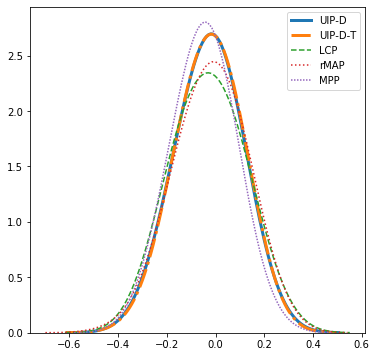

In [71]:
plt.figure(figsize=[6, 6])
bw = 0.1
sns.kdeplot(BiasDF["UIPD"],  ls=linestyles[0][1], label="UIP-D", bw=bw, lw=3)
sns.kdeplot(BiasDF["UIPD1"], ls=linestyles[3][1], label="UIP-D-T", bw=bw, lw=3)
sns.kdeplot(BiasDF["LCP"], ls=linestyles[2][1], label="LCP", bw=bw)
sns.kdeplot(BiasDF["rMAP"], ls=linestyles[1][1], label="rMAP", bw=bw)
sns.kdeplot(BiasDF["NPP"], ls=linestyles[5][1], label="MPP", bw=bw)


plt.savefig(saveDir/f"Bias_theta{int(theta0*100)}_MLE.pdf")

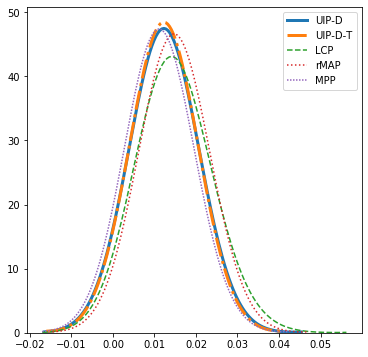

In [72]:
plt.figure(figsize=[6, 6])
bw = 0.008
sns.kdeplot(VarDF["UIPD"],  ls=linestyles[0][1], label="UIP-D", bw=bw, lw=3)
sns.kdeplot(VarDF["UIPD1"], ls=linestyles[3][1], label="UIP-D-T", bw=bw, lw=3)
sns.kdeplot(VarDF["LCP"], ls=linestyles[2][1], label="LCP", bw=bw)
sns.kdeplot(VarDF["rMAP"], ls=linestyles[1][1], label="rMAP", bw=bw)
sns.kdeplot(VarDF["NPP"], ls=linestyles[5][1], label="MPP", bw=bw)

plt.savefig(saveDir/f"Var_theta{int(theta0*100)}_MLE.pdf")

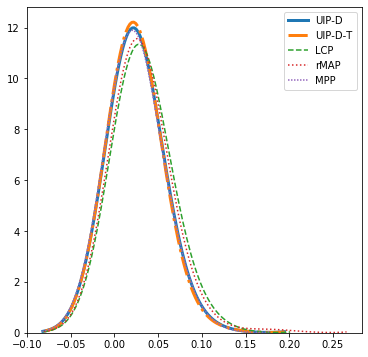

In [73]:
plt.figure(figsize=[6, 6])
bw = 0.03
sns.kdeplot(MSEDF["UIPD"],  ls=linestyles[0][1], label="UIP-D", bw=bw, lw=3)
sns.kdeplot(MSEDF["UIPD1"], ls=linestyles[3][1], label="UIP-D-T", bw=bw, lw=3)
sns.kdeplot(MSEDF["LCP"], ls=linestyles[2][1], label="LCP", bw=bw)
sns.kdeplot(MSEDF["rMAP"], ls=linestyles[1][1], label="rMAP", bw=bw)
sns.kdeplot(MSEDF["NPP"], ls=linestyles[5][1], label="MPP", bw=bw)

plt.savefig(saveDir/f"MSE_theta{int(theta0*100)}_MLE.pdf")